In [1]:
%matplotlib inline

import pandas as pd
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
from scipy.stats import kendalltau
import numpy as np

import scanpy as sc

import sys
sys.path.append('/home/ngr4/project/scnd/scripts/')
import dge_scnd as scnddge

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

# redo DGE

In [ ]:
import importlib
importlib.reload(scnddge)

In [8]:
def snrnaVmfish_redodge(adata,
                        imp=False,
                        timepoints=[5, 18, 30],
                        WTdir='down', 
                        fish_file='/home/ngr4/project/scnd/results/210716_merfish_de.csv', 
                        ctype = 'Purkinje cell',
                        out_file=None,
                        dge_out=None):
    '''Compare snRNA-seq to MERFISH DGE analysis via correlation & scatterplots
    
    Arguments:
      dge_file_magic (str or None): (optional, Default='/home/ngr4/project/scnd/results/dge*{}wk*_imp*down*csv')
        enter formula to find via glob files with {} indicating grouping, indicated by `timepoints` arg.
      WTdir (str): 'up' indicates that +EMD and l2fc values mean higher exp in WT; 'down' means the opposite
         
      
    '''
    
    fish = pd.read_csv(fish_file)
    results = pd.DataFrame()
    dge = pd.DataFrame()
    
    goi = fish.iloc[1:, 0]
    gene_idx = np.where(adata.var.index.isin(goi.to_list()))[0]
    gene_names = adata.var.index[gene_idx].to_list()
    
    for t in timepoints:
        A = adata[((adata.obs['ctype']==ctype) & 
               (adata.obs['genotype']=='WT') & 
               (adata.obs['timepoint']=='{}wk'.format(t))), :]
        B = adata[((adata.obs['ctype']==ctype) & 
                       (adata.obs['genotype']=='SCA1') & 
                       (adata.obs['timepoint']=='{}wk'.format(t))), :]
        idx = np.where(fish.columns=='{}wk'.format(t))[0][0]
        dt = fish.iloc[1:, [0, idx, idx+1]]
        dt.columns = ['Gene', 'mfish_l2fc', 'mfish_padj']
        
        if not imp:
            wt = np.asarray(A.X[:, gene_idx].todense())
            mut = np.asarray(B.X[:, gene_idx].todense())
        elif imp:
            wt = np.asarray(A.layers['imputed'][:, gene_idx])
            mut = np.asarray(B.layers['imputed'][:, gene_idx])
        
        if WTdir == 'up':
            d = scnddge.dge(wt, mut, gene_names)
        elif WTdir=='down':
            d = scnddge.dge(mut, wt, gene_names)
            
        corr_df = d.merge(dt, left_on='Gene', right_on='Gene')
        rho_padj, p_rho_padj = pearsonr(corr_df['pval_corrected'], corr_df['mfish_padj'].astype(float))
        tau_padj, p_tau_padj = kendalltau(corr_df['pval_corrected'], corr_df['mfish_padj'].astype(float))
        rho_l2fc, p_rho_l2fc = pearsonr(corr_df['log2FC'], corr_df['mfish_l2fc'].astype(float))
        tau_l2fc, p_tau_l2fc = kendalltau(corr_df['log2FC'], corr_df['mfish_l2fc'].astype(float))

        print('    rho_padj: {:.4f} ({:.4f})\ttau_padj:  {:.4f} ({:.4f})\trho_l2fc: {:.4f} ({:.4f})\ttau_l2fc: {:.4f} ({:.4f})'.format(
            rho_padj, p_rho_padj, tau_padj, p_tau_padj, rho_l2fc, p_rho_l2fc, tau_l2fc, p_tau_l2fc))

        results  = results.append(pd.DataFrame({'Gene':corr_df['Gene'],
                                               'timepoint':['{}wk'.format(t)]*corr_df.shape[0],
                                               'padj':corr_df['pval_corrected'],
                                               'l2fc':corr_df['log2FC'],
                                               'mfish_padj':corr_df['mfish_padj'].astype(float),
                                               'mfish_l2fc':corr_df['mfish_l2fc'].astype(float)}), ignore_index=True)
        d['timepoint'] = ['{}wk'.format(t)]*d.shape[0]
        d['ctype'] = [ctype]*d.shape[0]
        dge = dge.append(d, ignore_index=True)

    if dge_out is not None:
        dge.to_csv(dge_out)

    # plot
    fig, ax = plt.subplots(1, 2, figsize=(9,3))
    results['-log10 P adj'] = -1*np.log10(results['padj'])
    results['-log10 P adj (MERFISH)'] = -1*np.log10(results['mfish_padj'])
    sns.scatterplot(x='-log10 P adj', y='-log10 P adj (MERFISH)', data=results, 
                    hue='timepoint', linewidth=0, ax=ax[0])
    sns.scatterplot(x='l2fc', y='mfish_l2fc', data=results, 
                    hue='timepoint', linewidth=0, ax=ax[1])

    if out_file is not None:
        results.to_csv(out_file)

    return results
    


 p-val not calculable for Zfp488


 p-val not calculable for Gpr17

    rho_padj: 0.0735 (0.3949)	tau_padj:  0.0778 (0.1809)	rho_l2fc: 0.0256 (0.7674)	tau_l2fc: -0.0520 (0.3695)


/home/ngr4/project/scnd/scripts/dge_scnd.py:70: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)+eps) - np.log2(Y.mean(axis=0)+eps)})
/home/ngr4/project/scnd/scripts/dge_scnd.py:70: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)+eps) - np.log2(Y.mean(axis=0)+eps)})



 p-val not calculable for Trf


 p-val not calculable for Gpr17

    rho_padj: 0.0839 (0.3314)	tau_padj:  0.1633 (0.0050)	rho_l2fc: -0.1873 (0.0290)	tau_l2fc: -0.1521 (0.0087)


/home/ngr4/project/scnd/scripts/dge_scnd.py:70: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)+eps) - np.log2(Y.mean(axis=0)+eps)})
/home/ngr4/project/scnd/scripts/dge_scnd.py:70: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)+eps) - np.log2(Y.mean(axis=0)+eps)})



 p-val not calculable for Lum


 p-val not calculable for Trf


 p-val not calculable for Olig2


 p-val not calculable for Baiap3


 p-val not calculable for Gpr17

    rho_padj: -0.0849 (0.3259)	tau_padj:  0.0125 (0.8301)	rho_l2fc: 0.1366 (0.1127)	tau_l2fc: 0.1868 (0.0013)


/home/ngr4/project/scnd/scripts/dge_scnd.py:70: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)+eps) - np.log2(Y.mean(axis=0)+eps)})
/home/ngr4/project/scnd/scripts/dge_scnd.py:70: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)+eps) - np.log2(Y.mean(axis=0)+eps)})



 p-val not calculable for Zfp488


 p-val not calculable for Gpr17

    rho_padj: 0.0735 (0.3949)	tau_padj:  0.0778 (0.1809)	rho_l2fc: -0.0256 (0.7674)	tau_l2fc: 0.0520 (0.3695)


/home/ngr4/project/scnd/scripts/dge_scnd.py:70: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)+eps) - np.log2(Y.mean(axis=0)+eps)})
/home/ngr4/project/scnd/scripts/dge_scnd.py:70: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)+eps) - np.log2(Y.mean(axis=0)+eps)})



 p-val not calculable for Trf


 p-val not calculable for Gpr17

    rho_padj: 0.0839 (0.3314)	tau_padj:  0.1633 (0.0050)	rho_l2fc: 0.1873 (0.0290)	tau_l2fc: 0.1521 (0.0087)


/home/ngr4/project/scnd/scripts/dge_scnd.py:70: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)+eps) - np.log2(Y.mean(axis=0)+eps)})
/home/ngr4/project/scnd/scripts/dge_scnd.py:70: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)+eps) - np.log2(Y.mean(axis=0)+eps)})



 p-val not calculable for Lum


 p-val not calculable for Trf


 p-val not calculable for Olig2


 p-val not calculable for Baiap3


 p-val not calculable for Gpr17

    rho_padj: -0.0849 (0.3259)	tau_padj:  0.0125 (0.8301)	rho_l2fc: -0.1366 (0.1127)	tau_l2fc: -0.1868 (0.0013)


/home/ngr4/project/scnd/scripts/dge_scnd.py:70: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)+eps) - np.log2(Y.mean(axis=0)+eps)})
/home/ngr4/project/scnd/scripts/dge_scnd.py:70: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)+eps) - np.log2(Y.mean(axis=0)+eps)})


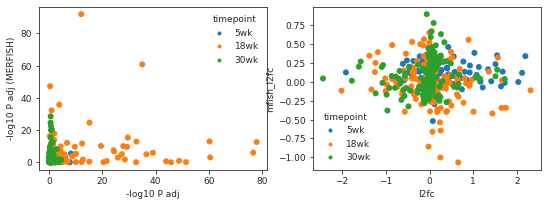

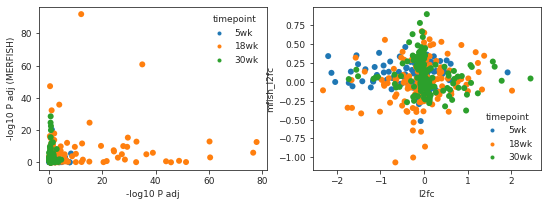

In [10]:
# main
imp = False

if not imp:
    adata = sc.read('/home/ngr4/project/scnd/data/processed/mouse_200614.h5ad')
    u = snrnaVmfish_redodge(adata,
                        WTdir='up', 
                        out_file='/home/ngr4/project/scnd/results/dge_snrnaVmfish_nonimp_WTup.csv',
                        dge_out='/home/ngr4/project/scnd/results/dge_redo_nonimp_PC_WTup.csv')
    d = snrnaVmfish_redodge(adata,
                        WTdir='down', 
                        out_file='/home/ngr4/project/scnd/results/dge_snrnaVmfish_nonimp_WTdown.csv',
                        dge_out='/home/ngr4/project/scnd/results/dge_redo_nonimp_PC_WTdown.csv')
elif imp:
    # need >64GB RAM
    wt = sc.read('/home/ngr4/project/scnd/data/processed/mouse_wt_imputed.h5ad')
    del wt.obsp
    wt = wt[(wt.obs['ctype']=='Purkinje cell')]

    mut = sc.read('/home/ngr4/project/scnd/data/processed/mouse_sca1_imputed.h5ad')
    del mut.obsp
    mut = mut[(mut.obs['ctype']=='Purkinje cell')]

    adata = wt.concatenate(mut, batch_key='imp_source', batch_categories=['wt', 'mut'])
    del wt, mut
    
    
    u_imp = snrnaVmfish_redodge(adata,
                        imp=True,
                        WTdir='up', 
                        out_file='/home/ngr4/project/scnd/results/dge_snrnaVmfish_imp_WTup.csv',
                        dge_out='/home/ngr4/project/scnd/results/dge_redo_imp_PC_WTup.csv')
    d_imp = snrnaVmfish_redodge(adata,
                        imp=True,
                        WTdir='down', 
                        out_file='/home/ngr4/project/scnd/results/dge_snrnaVmfish_imp_WTdown.csv',
                        dge_out='/home/ngr4/project/scnd/results/dge_redo_imp_PC_WTdown.csv')

# don't re-do DGE

In [ ]:
def snrnaVmfish(dge_file_magic='/home/ngr4/project/scnd/results/dge*{}wk*_imp*down*csv',
                timepoints=[5, 18, 30],
                fish_file='/home/ngr4/project/scnd/results/210716_merfish_de.csv', 
                ctype = 'Purkinje cell',
                out_file=None,
                redo_dge=False):
    '''Compare snRNA-seq to MERFISH DGE analysis via correlation & scatterplots
    
    Arguments:
      dge_file_magic (str or None): (optional, Default='/home/ngr4/project/scnd/results/dge*{}wk*_imp*down*csv')
        enter formula to find via glob files with {} indicating grouping, indicated by `timepoints` arg. If None,
         
      
    '''
    
    fish = pd.read_csv(fish_file)
    results = pd.DataFrame()
    
    for t in timepoints:
        files = glob.glob(dge_file_magic.format(t))
        for i, f in enumerate(files):
            print('\n  processing file #{}: {}'.format(i, f))
        d = pd.read_csv(files[0])
        d = d.loc[d['Cell type']=='Purkinje cell', :]
        idx = np.where(fish.columns=='{}wk'.format(t))[0][0]
        dt = fish.iloc[1:, [0, idx, idx+1]]
        dt.columns = ['Gene', 'mfish_l2fc', 'mfish_padj']
        corr_df = d.merge(dt, left_on='Gene', right_on='Gene')
        rho_padj, p_rho_padj = pearsonr(corr_df['pval_corrected'], corr_df['mfish_padj'].astype(float))
        tau_padj, p_tau_padj = kendalltau(corr_df['pval_corrected'], corr_df['mfish_padj'].astype(float))
        rho_l2fc, p_rho_l2fc = pearsonr(corr_df['log2FC'], corr_df['mfish_l2fc'].astype(float))
        tau_l2fc, p_tau_l2fc = kendalltau(corr_df['log2FC'], corr_df['mfish_l2fc'].astype(float))

        print('    rho_padj: {:.4f} ({:.4f})\ttau_padj:  {:.4f} ({:.4f})\trho_l2fc: {:.4f} ({:.4f})\ttau_l2fc: {:.4f} ({:.4f})'.format(
            rho_padj, p_rho_padj, tau_padj, p_tau_padj, rho_l2fc, p_rho_l2fc, tau_l2fc, p_tau_l2fc))

        results  = results.append(pd.DataFrame({'Gene':corr_df['Gene'],
                                               'timepoint':['{}wk'.format(t)]*corr_df.shape[0],
                                               'padj':corr_df['pval_corrected'],
                                               'l2fc':corr_df['log2FC'],
                                               'mfish_padj':corr_df['mfish_padj'].astype(float),
                                               'mfish_l2fc':corr_df['mfish_l2fc'].astype(float)}), ignore_index=True)

    # plot
    fig, ax = plt.subplots(1, 2, figsize=(9,3))
    results['-log10 P adj'] = -1*np.log10(results['padj'])
    results['-log10 P adj (MERFISH)'] = -1*np.log10(results['mfish_padj'])
    sns.scatterplot(x='-log10 P adj', y='-log10 P adj (MERFISH)', data=results, 
                    hue='timepoint', linewidth=0, ax=ax[0])
    sns.scatterplot(x='l2fc', y='mfish_l2fc', data=results, 
                    hue='timepoint', linewidth=0, ax=ax[1])
    
    if out_file is not None:
        results.to_csv(out_file)
    

In [ ]:
snrnaVmfish(dge_file_magic='/home/ngr4/project/scnd/results/dge*{}wk*_imp*down*csv',
            out_file='/home/ngr4/project/scnd/results/dge_snrnaVmfish_imp_WTdown.csv')
snrnaVmfish(dge_file_magic='/home/ngr4/project/scnd/results/dge*{}wk*_imp*up*csv',
            out_file='/home/ngr4/project/scnd/results/dge_snrnaVmfish_imp_WTup.csv')